Кумулятивний дохід по днях для кожної із компаній за останні 2 тижні

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

spark = SparkSession.builder \
    .appName("SimpleApp") \
    .getOrCreate()

your 131072x1 screen size is bogus. expect trouble
25/04/15 12:29:59 WARN Utils: Your hostname, DESKTOP-DP2FLCF resolves to a loopback address: 127.0.1.1; using 172.22.104.161 instead (on interface eth0)
25/04/15 12:29:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/15 12:30:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/15 12:30:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/04/15 12:30:03 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
df_fare_init = spark.read.option("header", True).option("inferSchema", True).csv("../data_lake/trip_fare_1.csv")
df_trip_init = spark.read.option("header", True).option("inferSchema", True).csv("../data_lake/trip_data_1.csv")

In [3]:
for column in df_fare_init.columns:
    df_fare_init = df_fare_init.withColumnRenamed(column, column.strip().replace(" ", "_"))

In [4]:
from pyspark.sql.functions import lit

df_trip = df_trip_init.filter(
    (col("passenger_count") > 0) & (col("passenger_count") <= 10) &
    (col("trip_time_in_secs") > 0) &
    (col("trip_distance") > 0) &
    (col("pickup_latitude").between(40.5, 41.0)) &
    (col("dropoff_latitude").between(40.5, 41.0)) &
    (col("pickup_longitude").between(-74.5, -73.0)) &
    (col("dropoff_longitude").between(-74.5, -73.0)) &
    (col("pickup_datetime") <= lit("2013-01-27"))
)

df_fare = df_fare_init.filter(
    (col("fare_amount") >= 0) &
    (col("tip_amount") >= 0) &
    (col("tolls_amount") >= 0) &
    (col("total_amount") >= 0) &
    (col("fare_amount") > 0) &
    (col("pickup_datetime") <= lit("2013-01-27"))
)

In [5]:
from pyspark.sql.functions import max, min, col, to_date, trunc

df = df_trip.join(df_fare, on=["medallion", "hack_license", "pickup_datetime", "vendor_id"])

# max_date = df.select(max("pickup_datetime")).first()[0]

In [6]:
from pyspark.sql.functions import col, hour, when, to_date, max as Fmax, date_sub, expr, avg, round as Fround
from pyspark.sql.functions import col, to_date, max as Fmax, date_sub, sum as Fsum


In [8]:
# Максимальна дата

week_start = date_sub(lit("2013-01-27"), 6)




In [8]:
from pyspark.sql.functions import to_date, col, max as Fmax, date_sub, sum as Fsum
from pyspark.sql.window import Window

# 1. Знаходимо максимальну дату
# max_date = df.select(Fmax("pickup_datetime")).first()[0]
start_date = date_sub(lit("2013-01-27"), 13)

# # 2. Фільтруємо по останніх 30 днях
# df_last_month = df.withColumn("trip_date", to_date("pickup_datetime")) \
#     .filter(col("trip_date") >= start_date)


In [9]:
from pyspark.sql.functions import col, to_date, date_format, sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.functions import last

# 1. Фільтруємо останній місяць
df_last_month = df.withColumn("trip_date", to_date("pickup_datetime")) \
    .filter(col("trip_date") >= start_date)

# 2. Агрегуємо денний дохід
df_daily_income = df_last_month.groupBy("vendor_id", "trip_date").agg(
    Fsum("total_amount").alias("daily_income")
)

# 3. Додаємо кумулятивну суму
window_spec = Window.partitionBy("vendor_id").orderBy("trip_date") \
    .rowsBetween(Window.unboundedPreceding, Window.currentRow)

df_cumulative = df_daily_income.withColumn(
    "cumulative_income", Fsum("daily_income").over(window_spec)
)

# 4. Форматуємо дату як рядок
df_cumulative = df_cumulative.withColumn("trip_date_str", date_format("trip_date", "yyyy-MM-dd"))

# 5. Pivot: робимо vendor_id стовпцями
df_pivot = df_cumulative.groupBy("trip_date_str") \
    .pivot("vendor_id") \
    .agg(Fsum("cumulative_income")) \
    .orderBy("trip_date_str")


for vendor_col in df_pivot.columns[1:]:
    window_ffill = Window.orderBy("trip_date_str").rowsBetween(Window.unboundedPreceding, 0)
    df_pivot = df_pivot.withColumn(
        vendor_col,
        last(col(vendor_col), ignorenulls=True).over(window_ffill)
    )


25/04/15 12:43:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 12:43:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 12:43:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 12:43:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 12:43:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 12:43:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 12:43:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 12:43:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 12:43:50 WARN RowBasedKeyValueBatch: Calling spill() on

In [10]:
df_pivot.show(28, truncate=False)


25/04/15 12:44:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/15 12:44:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/15 12:44:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/15 12:44:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/15 12:44:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/15 12:45:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/15 1

+-------------+--------------------+--------------------+
|trip_date_str|CMT                 |VTS                 |
+-------------+--------------------+--------------------+
|2013-01-14   |3017921.299999974   |2981197.249999986   |
|2013-01-15   |6334355.699999943   |6320613.199999964   |
|2013-01-16   |9727538.88999991    |9752008.649999944   |
|2013-01-17   |1.3063868959999876E7|1.3318285669999918E7|
|2013-01-18   |1.5739126219999857E7|1.707058424999989E7 |
|2013-01-19   |1.7597589079999853E7|2.0408896439999875E7|
|2013-01-20   |1.935174981999985E7 |2.341707479999986E7 |
|2013-01-21   |2.111649081999985E7 |2.6012738289999846E7|
|2013-01-22   |2.341223855999984E7 |2.8886310239999834E7|
|2013-01-23   |2.5433658599999834E7|3.0198838579999834E7|
|2013-01-24   |2.6381050349999838E7|3.404883645999981E7 |
|2013-01-25   |2.726984352999984E7 |3.7732309319999784E7|
|2013-01-26   |2.8561922189999845E7|4.135597852999977E7 |
|2013-01-27   |2.8561966189999845E7|4.136010731999977E7 |
+-------------

25/04/14 19:11:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/14 19:11:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/14 19:11:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/14 19:11:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/14 19:11:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/14 19:11:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/14 19:11:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/14 19:11:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/14 19:11:44 WARN RowBasedKeyValueBatch: Calling spill() on

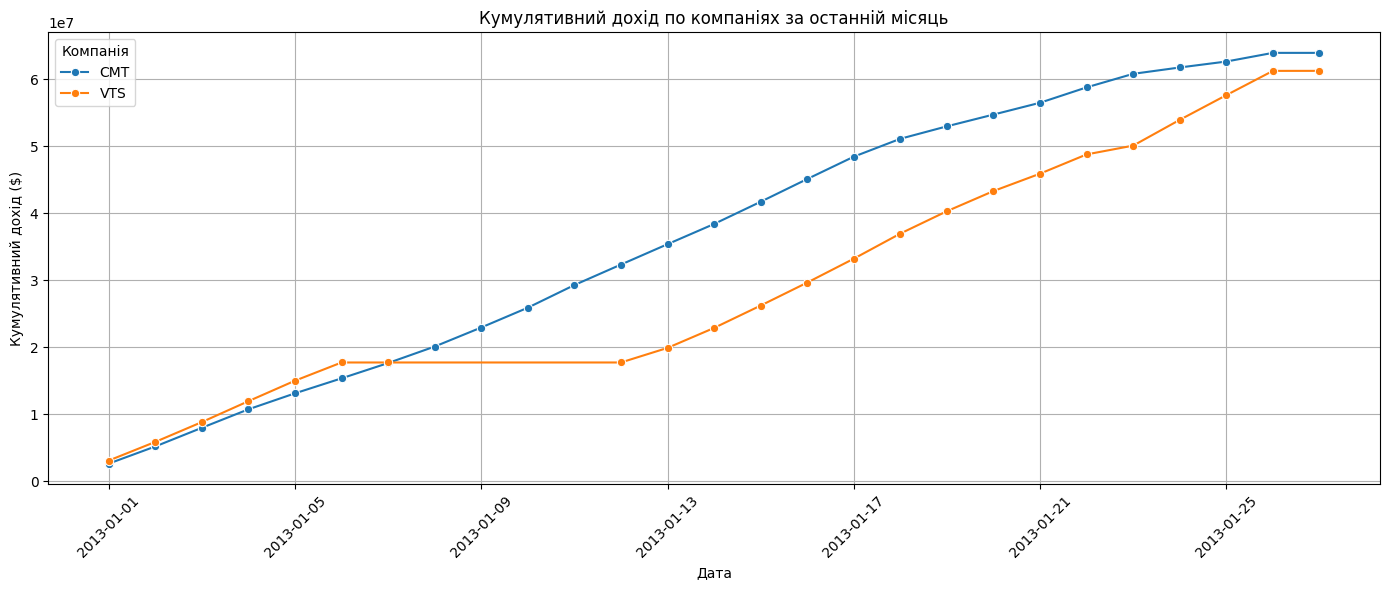

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # 1. Переносимо результат у Pandas
# pdf = df_cumulative.toPandas()

# # 2. Перетворюємо дату у формат datetime (на випадок, якщо ще не)
# pdf["trip_date"] = pd.to_datetime(pdf["trip_date"])

# # 3. Побудова графіку
# plt.figure(figsize=(14, 6))
# sns.lineplot(data=pdf, x="trip_date", y="cumulative_income", hue="vendor_id", marker="o")

# plt.title("Кумулятивний дохід по компаніях за останній місяць")
# plt.xlabel("Дата")
# plt.ylabel("Кумулятивний дохід ($)")
# plt.legend(title="Компанія")
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()
# plt.show()


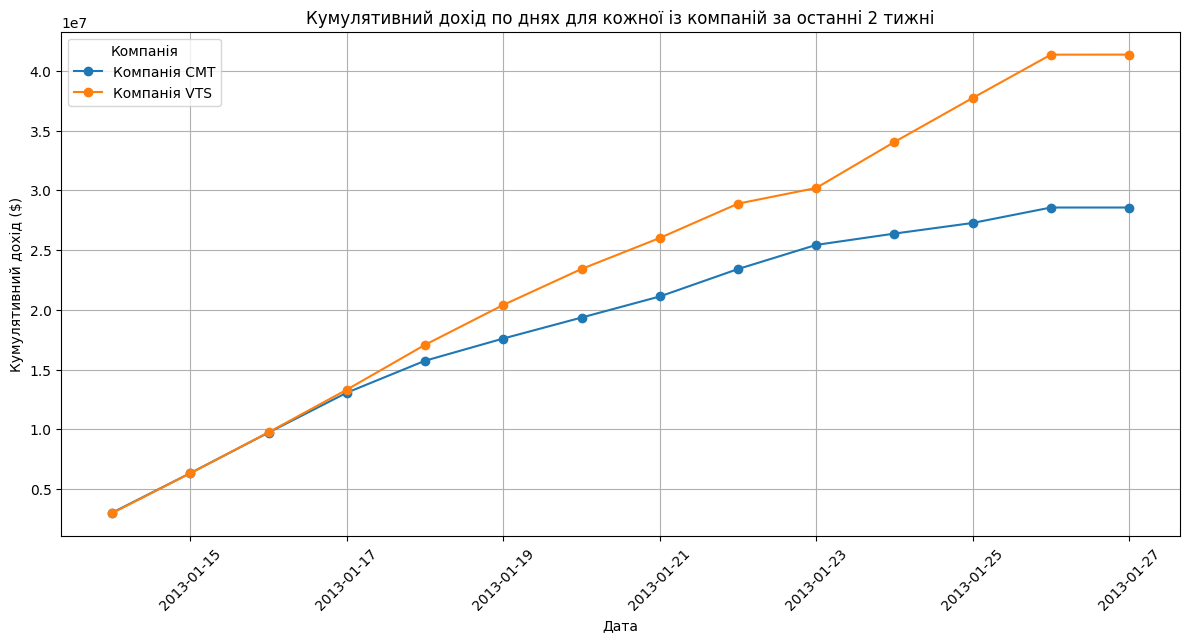

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
# Припустимо, df_pivot — це Spark DataFrame після forward fill
# Конвертуємо у Pandas DataFrame
pdf = df_pivot.toPandas()

# Преобразовуємо колонку з датами в datetime формат
pdf['trip_date_str'] = pd.to_datetime(pdf['trip_date_str'])

# Сортуємо за датою
pdf = pdf.sort_values('trip_date_str')

# Створюємо графік
plt.figure(figsize=(12, 6))

# Для кожної компанії малюємо лінію
for col in pdf.columns[1:]:  # Пропускаємо 'trip_date_str'
    plt.plot(pdf['trip_date_str'], pdf[col], label=f'Компанія {col}', marker='o' )

plt.title("Кумулятивний дохід по днях для кожної із компаній за останні 2 тижні")
plt.xlabel("Дата")
plt.ylabel("Кумулятивний дохід ($)")
plt.legend(title="Компанія")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()
